# **Notebook - skupina ŠPARK, téma COVID**

*15.5.2023*

Andrej Špitalský, Teo Pazera, Tomáš Antal, Rafael Rohaľ, Róbert Kendereš

Niektoré bunky sú pridané len pre ukážku kódu a algoritmu, napríklad za vytváraním vhodných dataframeov pre analýzu. Keďže ich spustenie ale trvá príliš dlho, tak sme predspracované dáta vygenerované týmito bunkami nahrali na stránku a bunku sme označili `%%script echo Skipped`, aby sa nespustila. Neskôr v notebooku potom sťahujeme potrebné spracované dáta zo stránky.
Napriek tomu, všetky takto označené bunky (až na jednu) sa dajú spustiť v prostredí Colab.

In [3]:
import pandas as pd
import numpy as np
from IPython.display import Markdown
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

[Odkaz na stránku, z ktorej čerpáme dáta.](http://www.st.fmph.uniba.sk/~spitalsky3/viz-projekt/viz-projekt.html)

# Pôvodné dáta

Dáta obsahujú informácie z troch sekvenčných behov, kde každý beh obsahuje údaje pre vzorky pacientov SARC-CoV-2. Pre každý sekvenčný beh existujú tri tabuľky: `results`, `reads` a `match`.

Pôvodné dáta boli získané z Univerzity Komenského.


# Spracovanie dát

Pre lepšiu manipuláciu s dostupnými dátami ich spojíme do jednej veľkej tabuľky. Pre každý z batchov 10, 11 a 12 príslušné tri tabuľky `reads`, `match` a `results` spojíme do jednej, ktorú nazveme `merged`.

## Použité funkcie

Výpis funkcií použitých v tejto kapitole.

In [4]:
def load_data(batch, typ):
  # načíta dáta z Davinci clustra, podľa čísla batchu a typu súboru, vráti df
  
  if typ in ('merged', 'coverage'):
    # merged a coverage majú inú štruktúru - pomenované stĺpce a index stĺpec
    return pd.read_csv(f'http://www.st.fmph.uniba.sk/~spitalsky3/viz-projekt/batch{batch}-{typ}.gz',
                     sep='\t', compression='gzip', index_col=0).sort_index()
  else:
    return pd.read_csv(f'http://www.st.fmph.uniba.sk/~spitalsky3/viz-projekt/batch{batch}-{typ}.gz',
                     sep='\t', header=None, compression='gzip')
    
  
def load_merge_match_reads(batch_num):
  '''
  argument je číslo batchu, načíta tabuľky reads a match pre daný batch
  spojí tabuľky dokopy podľa ID stĺpca a upraví do podoby, s ktorou 
    sa lepšie pracuje
  '''

  #načítanie dát
  test_match = load_data(str(batch_num), 'match')
  test_reads = load_data(str(batch_num), 'reads')

  # zmenenie poradia niektorých stĺpcov
  test_match[0], test_match[2] = test_match[2], test_match[0]
  test_reads[6], test_reads[7] = test_reads[7], test_reads[6]

  # stĺpcom pridáme výstižné názvy
  test_match = test_match.rename(columns={0:'ID', 1:'strand', 2:'matching', 3:'lengthMatch',
                                  4:'matchingStart', 5:'matchingEnd', 6:'referenceID',
                                  7:'referenceLength', 8:'referenceStart', 
                                  9:'referenceEnd', 10:'identicalPerc'})
  
  test_reads = test_reads.rename(columns={0:'ID', 1:'timeStart', 2:'lengthReads', 3:'estQuality',
                                          4:'barcode1', 5:'barcode2', 6:'barcode3',
                                          7:'organism', 8:'statusCode'})
  
  # spojíme dataframes podľa ID stĺpca a vrátime výsledný df
  merged = pd.merge(test_match, test_reads, how='inner', on='ID')
  merged.sort_values(by='ID', inplace=True)
  
  return merged


def add_results_to_merged(merged_df, batch_num):
  '''
  merged_df je výstup funkcie load_merge_match_reads
  podľa stĺpca barcode1 z merged_df namapuje hodnoty z tabuľky results
  pre unclassified v stĺpci barcode1 pridá NaN
  '''

  # načítanie tabuľky results, premenovanie stĺpcov
  results = load_data(batch_num, 'results')
  results = results.rename(columns={0:'barcode', 1:'notDetermined', 2:'numMutations', 3:'Pango',
                                            4:'probPango'})
  
  # podľa stĺpca 'barcode' pridáme stĺpec 'barcodeNum', kde bude uložená číselná hodnota
  barcodeNums = [int(val.removeprefix('barcode')) for val in list(results['barcode'])]
  results.insert(1, 'barcodeNum', barcodeNums)

  merged_all = merged_df.copy(deep=True)
  
  barcodeNum = list(results['barcodeNum']) # uložíme si všetky rôzne barcodes v tabuľke
  
  # prechádzame jednotlivé stĺpce results tabuľky
  # na základe barcode1 stĺpca ich pridávame do merged
  for column_name in results.columns:

    # stĺpce 'barcode' a 'barcodeNum' nepotrebujeme
    if column_name in ['barcode', 'barcodeNum']: continue

    # vytvoríme si slovník, kľúčom je barcode, hodnota je príslušna hodnota v results tabuľke
    values = list(results[column_name])
    dict_barcode_values = {f'{barcodeNum[i]:02d}': values[i] for i in range(len(barcodeNum))}
    dict_barcode_values['unclassified'] = np.nan

    # v merged tabuľke vytvoríme nový stĺpec, ktorý korešponduje so stĺpcom v results tabuľke
    # použijeme funkciu map, ktorá podľa stĺpca 'barcode1' a slovníka vytvorí nový stĺpec
    merged_all[column_name] = merged_all['barcode1'].map(dict_barcode_values)

  return merged_all


def add_period_to_barcode(df, period):
  # ku každej číselnej hodnote v stĺpcoch 'barcode1, 'barcode2', 'barcode3' pripočíta period*24
  
  # výsledný dataframe
  out = df.copy(deep=True)

  # vytvoríme slovník, kľúčom sú hodnoty barcodes od 1 po 24, hodnoty sú
  #   kľúč + period*24, resp.  pre 'unclassified' a 'none' je hodnota zhodná
  keys = [f'{i:02d}' for i in range(1, 25)]
  values = [f'{i:02d}' for i in range(1 + period * 24, 25 + period * 24)]

  dict_barcode_change = {keys[i]: values[i] for i in range(len(keys))}
  dict_barcode_change['unclassified'] = 'unclassified'
  dict_barcode_change['none'] = 'none'
  
  # pre každý stĺpec s barcodes, nahradíme ho stĺpcom s pripočítanými hodnotami
  for num in 1, 2, 3:
    out[f'barcode{num}'] = out[f'barcode{num}'].map(dict_barcode_change)

  return out

Vytvoríme `merged` tabuľky z pôvodných dát, pre každý s batchov 10, 11, 12. Následne už pracujeme skoro výhradne iba s týmito tabuľkami.

In [5]:
%%script echo Skipped

# pre každý batch spojíme tabuľky reads, match a results dokopy, vytvoríme súbor a stiahneme
batch_nums = [10, 11, 12]
for batch_num in batch_nums:
  tmp_merged_all = add_results_to_merged(load_merge_match_reads(batch_num), batch_num)
  tmp_merged_all.to_csv(f'batch{batch_num}-merged.gz', sep='\t', compression='gzip')
  # files.download(f'batch{batch_num}-merged.gz')

Skipped


Všetky `merged` tabuľky spojíme do jednej, pre prípad potreby analyzovania všetkých batchov naraz. Pridáme stĺpec `batchNum` pre spätní identifikáciu batchu a takisto k `barcode1` pripočítame 0, 24 alebo 48 po poradí pre batche 10, 11 a 12, aby rôzni pacienti nemali rovnaký identifikátor.

In [6]:
%%script echo Skipped

# stiahneme tabuľky 'merged' pre každý batch, pridáme identifikujúci stĺpec
merged10 = load_data(10, 'merged').insert(1,'batchNum', 10)
merged11 = load_data(11, 'merged').insert(1,'batchNum', 11)
merged12 = load_data(12, 'merged').insert(1,'batchNum', 12)

# barcodes pacientov posunieme o 24 alebo 48 pre batche 10, 11
merged11 = add_period_to_barcode(merged11, 1)
merged12 = add_period_to_barcode(merged12, 2)

# spojíme tabuľky, zoradíme podľa 'barcode1' a upravíme index
merged_all = pd.concat([merged10, merged11, merged12])
merged_all = merged_all.sort_index().sort_values(by='barcode1').reset_index(drop=True)

# vytvoríme súbor z merged all a stiahneme ho
merged_all.to_csv(f'batchall-merged.gz', sep='\t', compression='gzip')
# files.download(f'batchall-merged.gz')

Skipped


## Ukážka spracovaných dát

In [7]:
%%script echo Skipped

merged10 = load_data(10, 'merged')
display(merged10.sample(4).sort_index())

Skipped


#Hodnoty závislé od kvality

Načítame si dáta a priradíme ich do premennýh tab10

In [8]:
%%script echo Skipped

tab10 = load_data('10', 'merged')
tab11 = load_data('11', 'merged')
tab12 = load_data('12', 'merged')

Skipped


In [9]:
%%capture
tab_all = load_data('all', 'merged')

Najviac nás zaujímala estQuality/odhadovaná kvalita vzoriek, vedeli sme o nej veľmi málo a mali sme o nej už nejaké predpoklady.

##Prvý predpoklad -> že vieme odhadnúť varianty podľa estQuality

[Text(0.5, 0, 'estimated quality of the read'), Text(0, 0.5, 'Pango variant')]

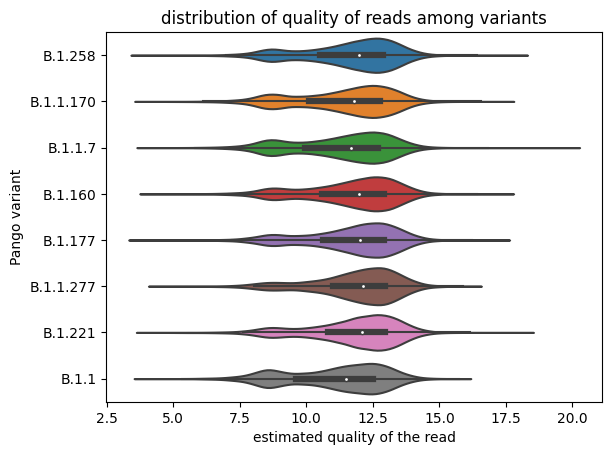

In [10]:
fig, axes = plt.subplots()

# violin plot for every dataframe
sns.violinplot(data=tab_all, x='estQuality', y='Pango')
# sns.violinplot(data=tab10, x='estQuality', y='Pango', ax=axes[0, 1])
# sns.violinplot(data=tab11, x='estQuality', y='Pango', ax=axes[1, 0])
# sns.violinplot(data=tab12, x='estQuality', y='Pango', ax=axes[1, 1])

# labels
axes.set_title('distribution of quality of reads among variants')
axes.set(xlabel='estimated quality of the read',ylabel='Pango variant')
# fig.savefig('rozdelenie variantov.png')
# files.download('rozdelenie variantov.png')
# axes[0, 1].set_title('tab10')
# axes[1, 0].set_title('tab11')
# axes[1, 1].set_title('tab12')

distribucia estQuality je pri kazdom variante skoro rovnaká, rozlíšiť ich teda nevieme

##Druhý predpoklad -> dĺžka readov je závislá od kvality readu

Text(0.5, 1.0, 'dependance of length on quality')

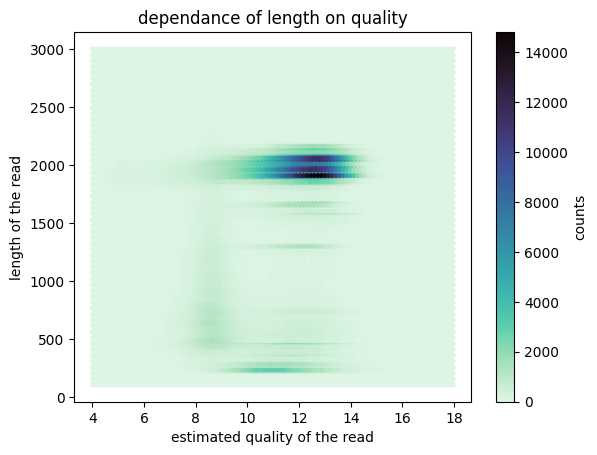

In [11]:
# dataframe s limitami, nech je lepsie vidno
df = tab_all.query('lengthReads <= 3000 and 4 <= estQuality <= 18')

# hexplot
hb = plt.hexbin(x=df['estQuality'], y=df['lengthReads'], cmap='mako_r')
cb = plt.colorbar(hb)
cb.set_label('counts')

# labels
plt.xlabel('estimated quality of the read')
plt.ylabel('length of the read')
plt.title('dependance of length on quality')

# plt.savefig('rozdelenie dlzky.png')
# files.download('rozdelenie dlzky.png')


Záver: je tam korelácia, ale veľmi slabá na to, aby sme vedeli dobre predpovedať dĺžku readu čisto podľa kvality.

##Dá sa podľa estimated quality odhadnúť čokoľvek iné?
Pozrime sa, či sa podľa danej estQuality dá odhadnúť niečo iné z tab_all

(len číselné hodnoty)

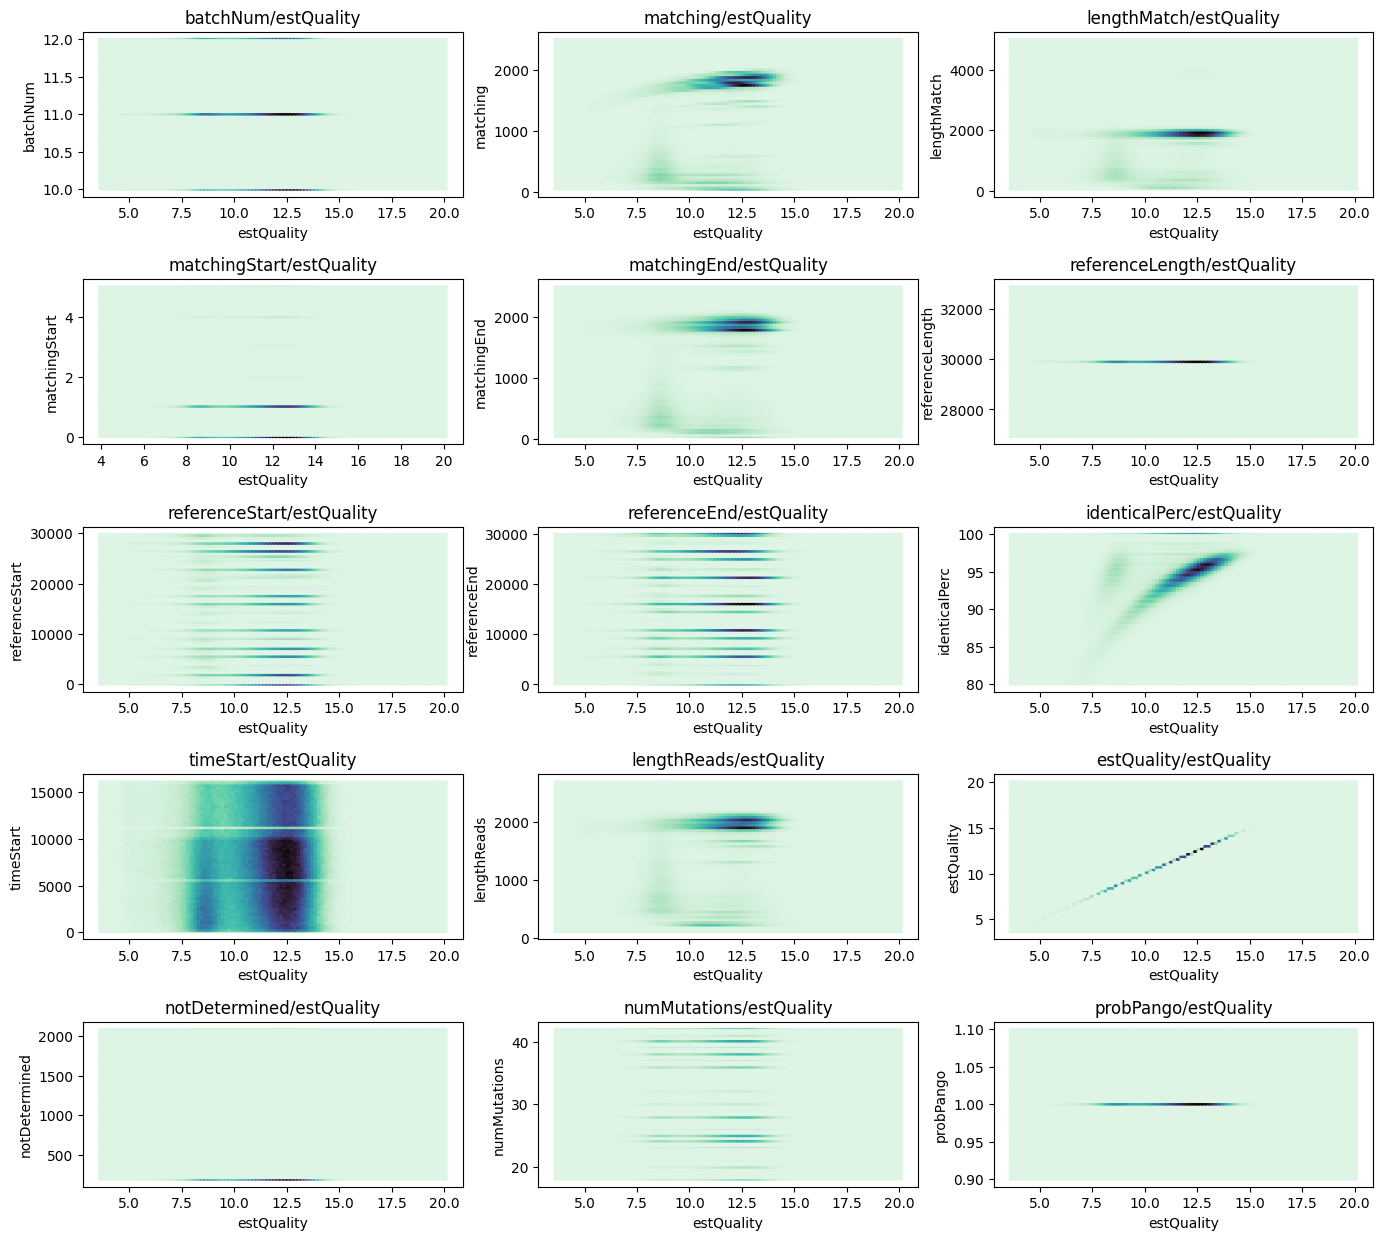

In [65]:
# select only numeric columns
tab_all_numeric_columns = list(tab_all.select_dtypes(include=np.number).columns)

fig, axes = plt.subplots(nrows=5, ncols=3, sharey=False, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

for i in range(5):
  for j in range(3):
    ax = axes[i, j]
    
    # column we compare estQuality with
    compare_column = tab_all_numeric_columns[int(i*3 + j)]
    
    # dataframe limits so the graphs are more 'zoomed in' for specific columns

    conditions_b = {'matching': '<= 2500',
                  'lengthMatch': '<= 5000', 
                  'matchingStart': '<= 5',
                  'matchingEnd': '<= 2500',
                  'referenceLength': ('29500 <=', '<= 30500'),
                  'identicalPerc': '>= 80',
                  'lengthReads': '<= 2700'
                  }
    
    conditions = {'matching': ('0 <=', '<= 2500'),
                  'lengthMatch': ('0 <=', '<= 5000'), 
                  'matchingStart': ('0 <=', '<= 5'),
                  'matchingEnd': ('0 <=', '<= 2500'),
                  'referenceLength': ('29500 <=', '<= 30500'),
                  'identicalPerc': ('80 <=', f'<= {int(max(tab_all[compare_column]))}'),
                  'lengthReads': ('0 <=', '<= 2700')
                  }

    # a = max(tab_all['identicalPerc'])
    # print(a)

    if compare_column not in conditions.keys():
      df = tab_all
    elif isinstance(conditions[compare_column], tuple):
      # upper and lower limits
      df = tab_all.query(f'{conditions[compare_column][0]} {compare_column} {conditions[compare_column][1]}')
    else:
      df = tab_all.query(f'{compare_column} {conditions[compare_column]}')

    # if compare_column == 'matching':
    #   df = tab_all.query('matching <= 2500')

    # elif compare_column == 'lengthMatch':
    #   df = tab_all.query('lengthMatch <= 5000')

    # elif compare_column == 'matchingStart':
    #   df = tab_all.query('matchingStart <= 5')

    # elif compare_column == 'matchingEnd':
    #   df = tab_all.query('matchingEnd <= 2500')

    # elif compare_column == 'referenceLength':
    #   df = tab_all.query('29500 <= referenceLength <= 30500')

    # elif compare_column == 'identicalPerc':
    #   df = tab_all.query('identicalPerc >= 80')

    # elif compare_column == 'lengthReads':
    #   df = tab_all.query('lengthReads <= 2700')

    # else:
    #   df = tab_all

    # hexplot
    ax.hexbin(x=df['estQuality'], y=df[compare_column], cmap='mako_r')

    # labels
    ax.set_xlabel('estQuality')
    ax.set_ylabel(compare_column)
    ax.set_title(f'{compare_column}/estQuality')

plt.show()

# fig.savefig('korelacie.png')
# files.download('korelacie.png')

Vidíme jemnú koreláci pre `matching` a takisto pre `identicalPerc`


Pozreli sme sa teda na tieto konkrétne prípady

#### `matching/estQuality:`

Text(0.5, 1.0, 'matching/estQuality relationship')

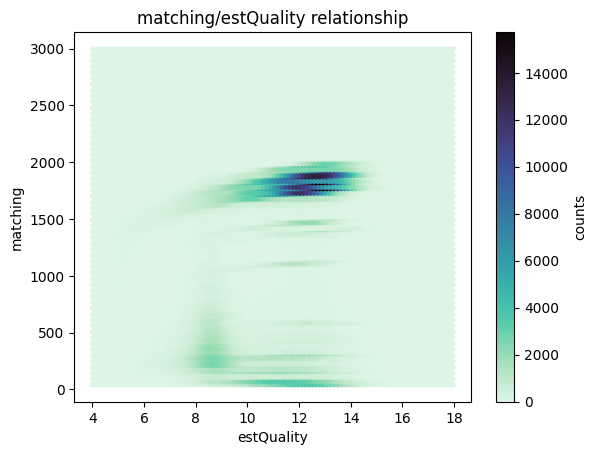

In [13]:
# dataframe s limitami, nech je lepsie vidno
df = tab_all.query('matching <= 3000 and 4 <= estQuality <= 18')

# hexplot
hb = plt.hexbin(x=df['estQuality'], y=df['matching'], cmap='mako_r')
cb = plt.colorbar(hb)
cb.set_label('counts')

# labels
plt.xlabel('estQuality')
plt.ylabel('matching')
plt.title('matching/estQuality relationship')

In [14]:
df = tab_all.query('matching <= 3000 and 4 <= estQuality <= 18')
corr = df['estQuality'].corr(df['matching'])
print('Correlation coefficient:', corr)

Correlation coefficient: 0.4018155215648511


**korelácia:** *0.4018* nie až tak prominentná

#### `identicalPerc/estQuality:`

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

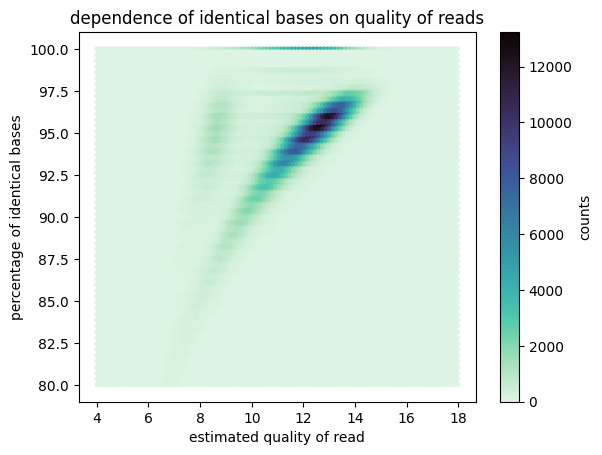

In [15]:
# dataframe s limitami, nech je lepsie vidno
df = tab_all.query('identicalPerc >= 80 and 4 <= estQuality <= 18')

# hexplot
hb = plt.hexbin(x=df['estQuality'], y=df['identicalPerc'], cmap='mako_r')
cb = plt.colorbar(hb)
cb.set_label('counts')

# labels
plt.xlabel('estimated quality of read')
plt.ylabel('percentage of identical bases')
plt.title('dependence of identical bases on quality of reads')

plt.savefig('idperc.png')
files.download('idperc.png')

In [16]:
df = tab_all.query('identicalPerc >= 80 and 4 <= estQuality <= 18')
corr = df['estQuality'].corr(df['identicalPerc'])
print('Correlation coefficient:', corr)

Correlation coefficient: 0.6271808801891103


**korelácia** : *0.6272*, potvrdili sme existenciu korelácie medzi identicalPerc a estQuality

Poďme sa teda pozrieť, s akou pravdepodobnosťou vieme podľa danej `estQuality` odhadnuť hodnoty pre `identicalPerc` a `matching` pomocou decision tree z knižnice **sklearn**, s ktorou sme pracovali aj na prednáškach

In [17]:
%%script echo Skipped

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Skipped


In [18]:
%%script echo Skipped

# trénovacie a testovacie sety
X_train, X_test, y_train, y_test = train_test_split(tab_all['estQuality'], tab_all['identicalPerc'], test_size=0.2)

# vytvorenie decision tree regressor 
dtree = DecisionTreeRegressor(max_depth=5)
dtree.fit(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy().reshape(-1, 1))

# predict na test dátach
y_pred = dtree.predict(X_test.to_numpy().reshape(-1, 1))

# mean squared error
mse = mean_squared_error(y_test, y_pred)

good_approximation = sum(abs(y_pred-y_test) < 2.5) / len(y_test)

print('Mean squared error:', mse)
print('Pravdepodobnosť dobrej aproximácie:', good_approximation)

Skipped


Pravdepodobnosť dobrej aproximácie pre `identicalPerc` je celkom vysoká, čiže si len potvrdzujeme koreláciu. `identicalPerc` je hodnota, ktorá najviac ovplyvňuje `estQuality`.

#Porovnanie Batchov


##Načítanie dataframov

In [19]:
merged10 = load_data('10', 'merged')
merged11 = load_data('11', 'merged')
merged12 = load_data('12', 'merged') 
merged_all = load_data('all', 'merged')
pass

<ipython-input-4-c01bda545b0b>:6: DtypeWarning: Columns (16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f'http://www.st.fmph.uniba.sk/~spitalsky3/viz-projekt/batch{batch}-{typ}.gz',


## Rozdelenie variantov medzi batchmi


## Výskyt organizmov ktoré neboli klasifikované ako target (covid)

In [20]:
def quant_vs_tar(tab):
  frequency_nontarget = []
  #vytvorime data frame obsahujuci v riadkoch postupne percentily estQuality
  quantile = [i for i in range(1,101)]
  premzoz = tab.quantile(q = [i/100 for i in quantile])['estQuality']
  for i in quantile:
    prem = premzoz[(i)/100]
    tmp = tab.query('estQuality <= @prem')
    frequency_nontarget.append(tmp.query('organism != "target"').shape[0] / tmp.shape[0])
    
  quantile_vs_target = pd.DataFrame({'percentile':quantile ,'frequency':frequency_nontarget})
  return quantile_vs_target

quant1 = quant_vs_tar(merged10)
quant2 = quant_vs_tar(merged11)
quant3 = quant_vs_tar(merged12)

<ipython-input-20-7773b012103a>:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  premzoz = tab.quantile(q = [i/100 for i in quantile])['estQuality']
<ipython-input-20-7773b012103a>:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  premzoz = tab.quantile(q = [i/100 for i in quantile])['estQuality']
<ipython-input-20-7773b012103a>:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  premzoz = tab.quantile(q = [i/100 for i in quantile])['estQuality']


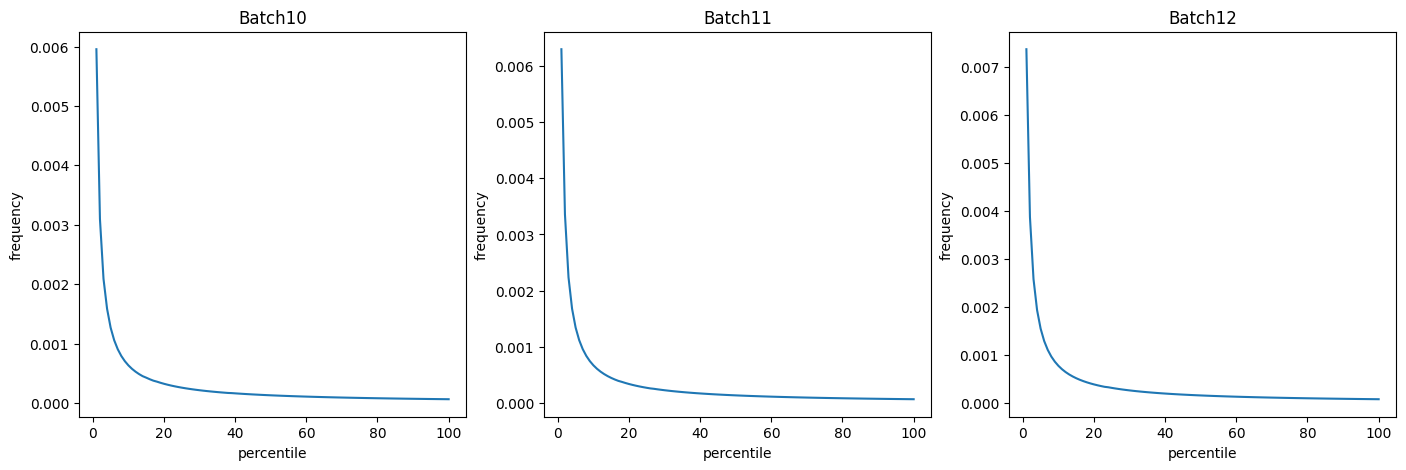

In [21]:
figure, axes = plt.subplots(1,3,figsize=(17,5))
sns.lineplot(data = quant1, x = 'percentile', y = 'frequency', ax=axes[0])
sns.lineplot(data = quant2, x = 'percentile', y = 'frequency', ax=axes[1])
sns.lineplot(data = quant3, x = 'percentile', y = 'frequency', ax=axes[2])
axes[0].set_title('Batch10')
axes[1].set_title('Batch11')
axes[2].set_title('Batch12')

pass

Podľa grafu vidíme klesajúcu tendenciu tohto výskytu čiže v čítaniach s vysokou kvalitou je týchto organizmov málo. V čítaniach s vysokou kvalitou sa skôr vyskytovali organizmy označené ako target (covid).

Vykreslili sme si rozdelenie variantov 

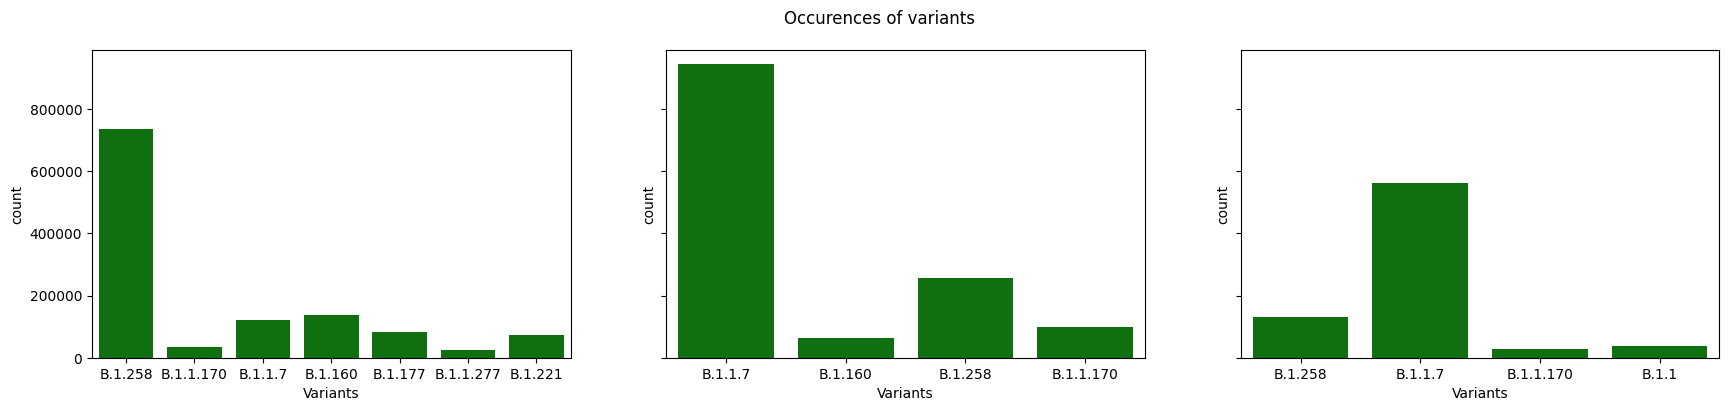

In [22]:
figure, axes = plt.subplots(1,3,figsize=(21,4), sharey=True)
sns.countplot(data=merged10, x = 'Pango', ax=axes[0],color='green')
sns.countplot(data=merged11, x = 'Pango', ax=axes[1],color='green')
sns.countplot(data=merged12, x = 'Pango', ax=axes[2], color='green')
for i in range(3):
  axes[i].set_xlabel('Variants')
figure.suptitle("Occurences of variants")
pass

Všimli sme si že sa výrazne zvýšil výskyt variantu B.1.1.7 tiež známy ako alpha variant. Preto sme graf prerobili a zvyraznili túto zmenu. Tiež sme zmenili countplot na klasicky histplot, ten teda na y-osi ukazuje s akou pravdepodobnosťou vyberieme aký variant.

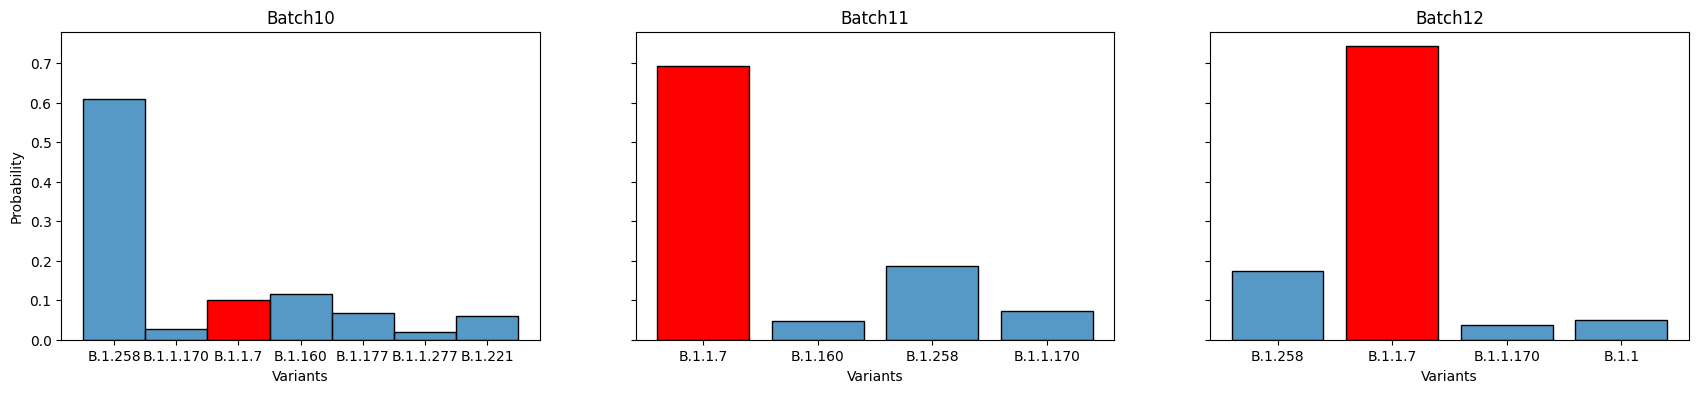

In [23]:
figure, axes = plt.subplots(1,3,figsize=(21,4), sharey=True)

sns.histplot(data=merged10, x = 'Pango',stat="probability", discrete=True, ax=axes[0])
sns.histplot(data=merged11, x = 'Pango',stat="probability", discrete=True, ax=axes[1], shrink=0.8)
sns.histplot(data=merged12, x = 'Pango',stat="probability", discrete=True, ax=axes[2], shrink=0.8)
for i in range(3):
  axes[i].set_xlabel('Variants')
patches = axes[0].patches
patches[2].set_fc('red')
patches = axes[1].patches
patches[0].set_fc('red')
patches = axes[2].patches
patches[1].set_fc('red')
axes[0].set_title('Batch10')
axes[1].set_title('Batch11')
axes[2].set_title('Batch12')
pass

##Rozdelenie kvality medzi batchmi

Pozreli sme sa na to či sa kvalita nijako mení medzi batchmi

In [24]:
for i,batch in enumerate((merged10,merged11, merged12)):
  display(round(batch['estQuality'].describe(),2))
  print('Median batchu',i+10)
  display(round(batch['estQuality'].median(),2))

count    1259532.00
mean          11.64
std            1.83
min            3.67
25%           10.69
50%           12.06
75%           12.95
max           18.17
Name: estQuality, dtype: float64

Median batchu 10


12.06

count    1429989.00
mean          11.21
std            1.93
min            3.63
25%            9.76
50%           11.63
75%           12.70
max           20.06
Name: estQuality, dtype: float64

Median batchu 11


11.63

count    800532.00
mean         11.04
std           1.90
min           3.81
25%           9.53
50%          11.47
75%          12.53
max          17.04
Name: estQuality, dtype: float64

Median batchu 12


11.47

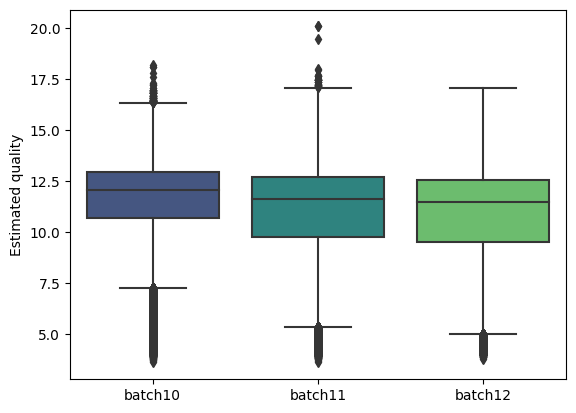

In [25]:
ax = sns.boxplot(data = [merged10['estQuality'], merged11['estQuality'], merged12['estQuality']], palette = 'viridis')
ax.set_xticklabels(['batch10', 'batch11', 'batch12'])
ax.set_ylabel('Estimated quality')
pass

Došli sme na to že je tu mierný pokles na kvalite postupne od batchu 10 po 12 keďže aj median, priemer, 1. kvantil aj 3. kvantil sú nižšie. Rovnaký rozdiel nám ukázal boxplot estQuality pre tieto tri batche.

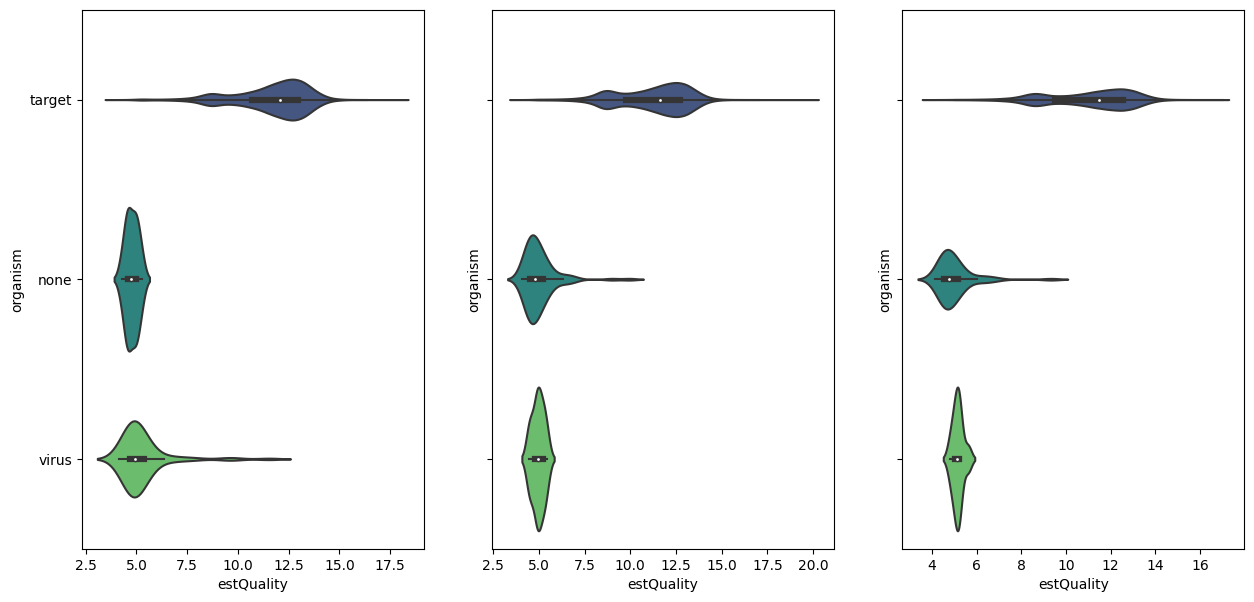

In [26]:
figure, axes = plt.subplots(1,3,figsize=(15,7),sharey=True)
sns.violinplot(data=merged10, x='estQuality', y='organism', ax=axes[0],palette = 'viridis')
sns.violinplot(data=merged11, x='estQuality', y='organism', ax=axes[1], palette = 'viridis')
sns.violinplot(data=merged12, x='estQuality', y='organism', ax=axes[2], palette = 'viridis')
pass

Tiež sme vykreslili takýto plot ktorý hovorí o rozdelení kvality medzi oranizmami, chceli sme vediet či sa nahodou nespráva inak medzi batchmi ale rozdieli sú zanedbateľné. 

## Počet non-targetov medzi batchmi + nízko kvalitné čítania + vysoko kvalitné čiatania + dlhé čítania 

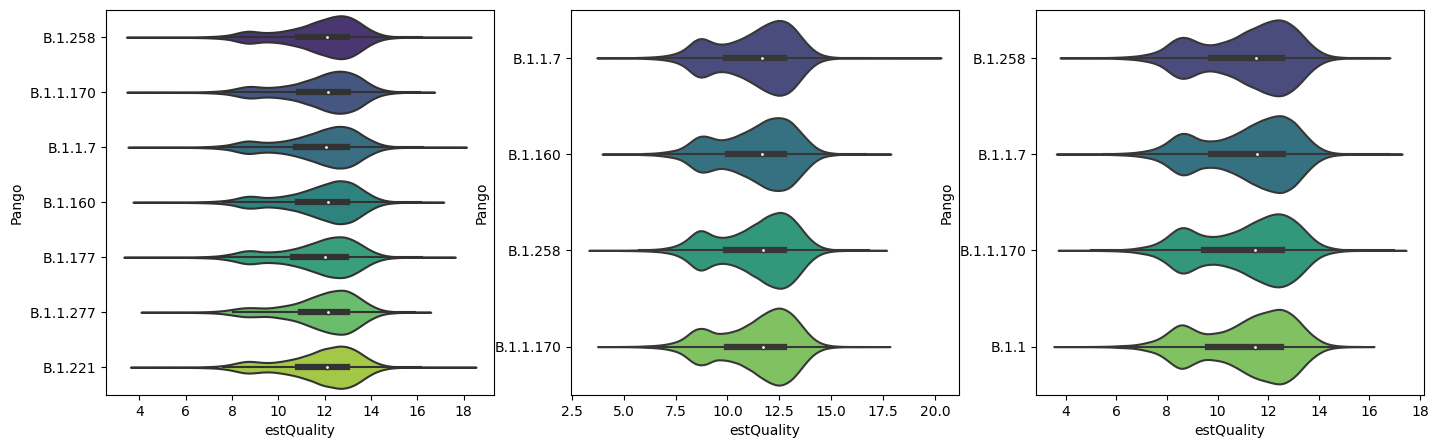

In [27]:
figure, axes = plt.subplots(1,3,figsize=(17,5))
sns.violinplot(data=merged10, x='estQuality', y='Pango', ax=axes[0],palette='viridis')
sns.violinplot(data=merged11, x='estQuality', y='Pango',ax=axes[1],palette='viridis')
sns.violinplot(data=merged12, x='estQuality', y='Pango', ax=axes[2],palette='viridis')
pass

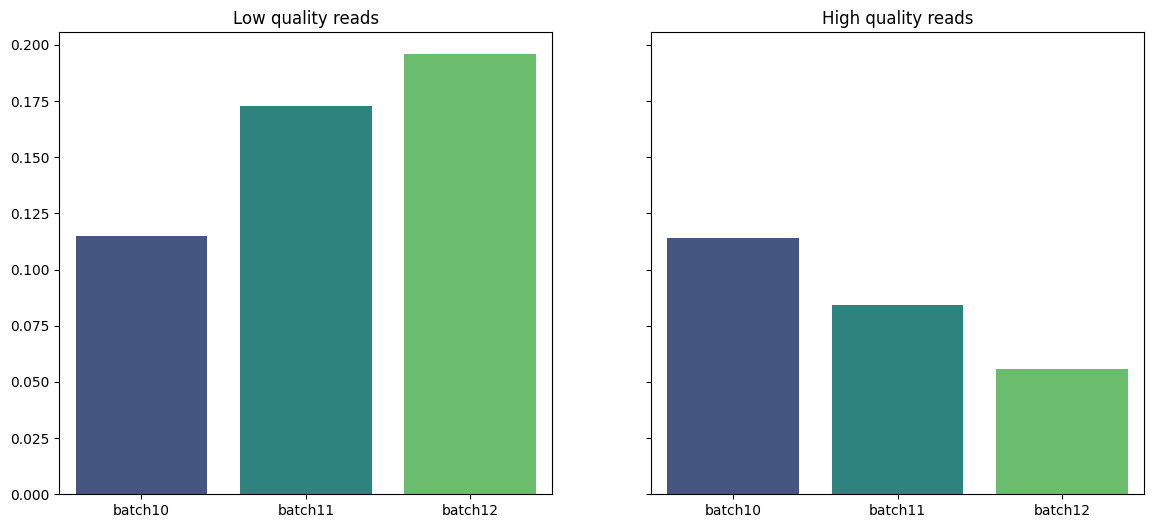

In [28]:
figure, axes = plt.subplots(1,2, figsize=(14,6), sharey=True)
zoznam2, zoznam3 = [], []
dlzka1, dlzka2, dlzka3 = len(merged10), len(merged11), len(merged12)


for tab in merged10, merged11, merged12:
  zoznam2.append(tab.query('estQuality <= 9').shape[0])
  zoznam3.append(tab.query('estQuality >= 13.5').shape[0])
  

sns.barplot(x = ['batch10', 'batch11', 'batch12'], y = [144932/dlzka1, 247145/dlzka2, 156753/dlzka3], ax=axes[0], palette='viridis')
sns.barplot(x = ['batch10', 'batch11', 'batch12'], y = [143431/dlzka1, 120251/dlzka2, 44640/dlzka3], ax=axes[1], palette='viridis')
axes[0].set_title('Low quality reads')
axes[1].set_title('High quality reads')
plt.savefig('quality_reads.png')
pass

#Čo spôsobilo pokles kvality medzi batchmi?


Spojili sme si zväčšenný výskyt alpha variantu medzi batchmi 11,12 a zníženie kvality v batchoch 11,12. Keďže má byť alpha variant viac zmutovaný oproti ostatným variantom, čakali sme pokles kvality kvôli vačšej odlišnosti od referenčn0mu genómu.

## Rozdelenie kvality v ramci batchov ukazuje opak

In [29]:
#upravená verzia funkcie aplha_vs_no_alpha  
def podmienka1_vs_podmienka2(podmienka1, podmienka2, label1, label2):
  figure, axes = plt.subplots(1,3, figsize=(20,7), sharey=True)
  number = 0
  for batch in merged10, merged11, merged12:
      #pre každy batch vyberieme čast dataframu ktorý splňa jednu podmienku a druhu čast čo splňa inú podmienku
      # obidve selectnute hodnoty vykreslime pre batche spolu
      sns.kdeplot(data = batch.query(podmienka1)['estQuality'], ax=axes[number], label = label1)
      sns.kdeplot(data = batch.query(podmienka2)['estQuality'], ax=axes[number], label = label2)
      # dostaneme distribuciu kvality v batchoch pričom jedna krivka hovori o distribucii s platnou podmienkou 1  a druha krivka s platnou podmienkou2

      number += 1
  for number, i in enumerate(['batch10', 'batch11', 'batch12']):
    axes[number].set_title(i)
  plt.legend()
pass

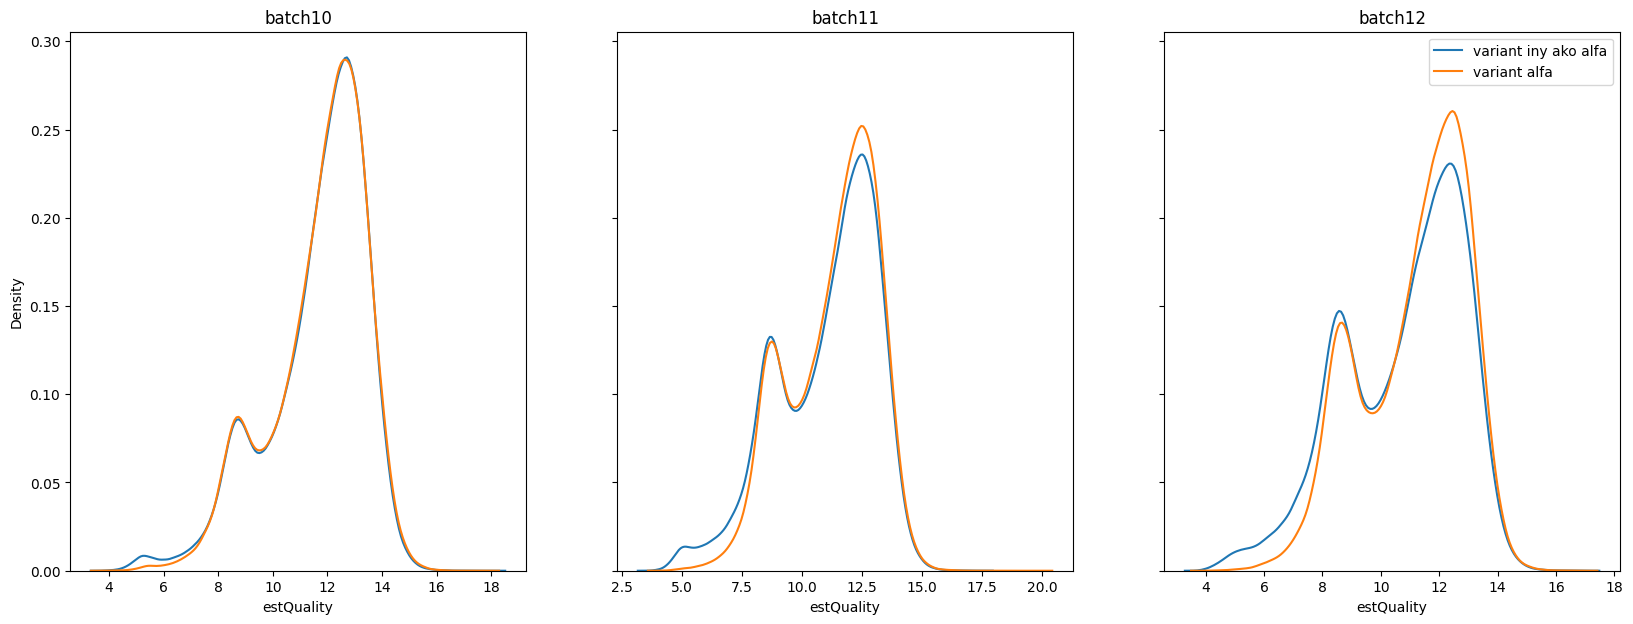

In [30]:
podmienka1_vs_podmienka2('Pango != "B.1.1.7"', 'Pango == "B.1.1.7"', "variant iny ako alfa", "variant alfa")

Vidíme, že kvalita v nizkých hodnotách má vačšie zastupenie pre ostatné ako alpha variant. Tiež vo vyšších hodnotách kvality má väčšie zastupenie alpha variant ako ostantne varianty. Z toho vyplýva, že náš predpoklad bol vyvrátený, keďže dáta hovoria o presne opačnom trende ako sme predpokladali.

##Hľadali sme ďalej čo by spôsobilo rozdiel kvality 

### V súbor results sem dostali informácie o počte neurčených báz pre pacienta

Načítali sme si dáta results do jedného dataframu kde pridáme ďalší stĺpec hovoriaci o tom z ktorého batchu pochádza pacient

In [31]:
results11 = load_data('11', 'results')
results12 = load_data('12', 'results')
results10 = load_data('10', 'results')
results10.rename(columns = {0:'pacient', 1:'NumNotdetermined_bases', 2:'NumMutations', 3:'Pango', 4:'Prob' }, inplace = True)
results11.rename(columns = {0:'pacient', 1:'NumNotdetermined_bases', 2:'NumMutations', 3:'Pango', 4:'Prob' }, inplace = True)
results12.rename(columns = {0:'pacient', 1:'NumNotdetermined_bases', 2:'NumMutations', 3:'Pango', 4:'Prob' }, inplace = True)
results10['batch']=results10.shape[0]*['10']
results11['batch']=results11.shape[0]*['11']
results12['batch']=results12.shape[0]*['12']
results_all = pd.concat([results10, results11, results12])
display(results_all)

,pacient,NumNotdetermined_bases,NumMutations,Pango,Prob,batch
0,barcode01,195,21,B.1.258,1.0,10
1,barcode02,193,21,B.1.1.170,1.0,10
2,barcode03,193,26,B.1.258,1.0,10
3,barcode04,193,24,B.1.258,1.0,10
4,barcode05,193,23,B.1.258,1.0,10
...,...,...,...,...,...,...
18,barcode19,191,39,B.1.1.7,1.0,12
19,barcode21,191,40,B.1.1.7,1.0,12
20,barcode22,191,39,B.1.1.7,1.0,12
21,barcode23,193,24,B.1.258,1.0,12


<Figure size 500x500 with 0 Axes>

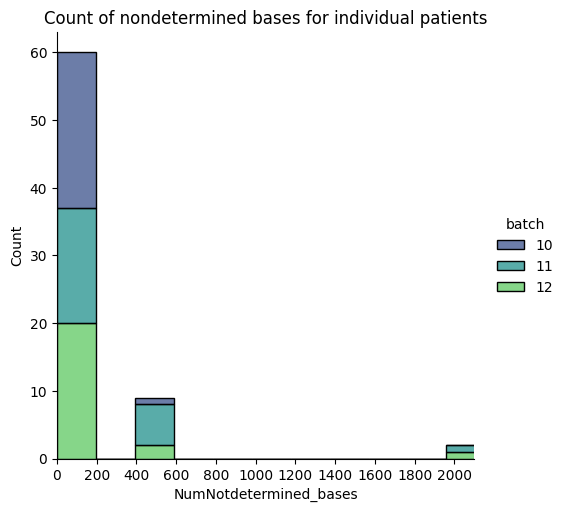

In [32]:
plt.figure(figsize=(5,5))
ax = sns.displot(data=results_all, x="NumNotdetermined_bases", hue="batch", multiple="stack", bins=range(0, 2301, 196), palette ='viridis')
ax.set(xlim=(100, 2100))
ax.set(title = 'Count of nondetermined bases for individual patients')
ax.set(xticks=(range(0,2100,200)))
pass

Väčšina pacientov vo všetkých batchoch mala okolo 190 až 200 neurčených báz. Ale v batchoch 11 a 12
bol počet týchto neurčených báz pri viacerých viac ako 200 okolo 560 a este aj 2000.
Tým že vieme o pacientoch ktorým neurčíme bázi menej dáva celkom zmysel a preto nám napadlo
že by to mohlo mať aj vplyv na kvalitu.

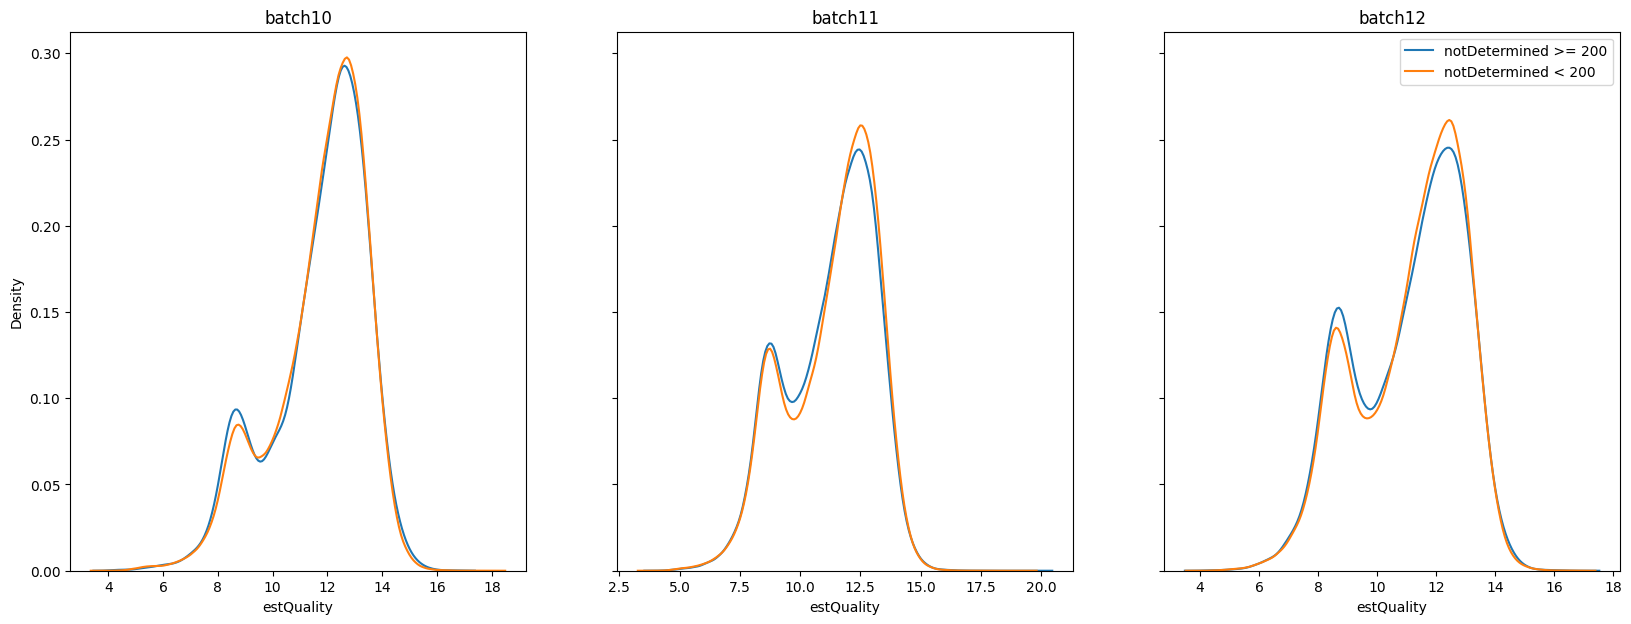

In [33]:
podmienka1_vs_podmienka2('notDetermined >= 200', 'notDetermined < 200','notDetermined >= 200','notDetermined < 200')
#spustime teda upravenú verziu funkcie pre neurčené bázy nad 200 a pod 200

Hypotéza sa nám potvrdila a tak ako vídime na grafe vieme si všimnuť že v každom batchi máme pre rozdelenie kvality dva vrcholy jeden okolo 8,5 a teda to je nižšia kvalita tu je krivka s 200 a viac neurčených báz nad druhou teda je viac nekvalitných readov pre 200 a viac neurčených báz a tiež okolo druhého vrchola kvality cca 12,5 je viac readov z menej ako 200 neurčenými bázami. 
Vieme povedať, že zvýšený počet pacientov z viac ako 200 neurčenými bázami spôsobil zniženie kvality.

## Rozdelenie čítaní z pôvodnej analýzy UK


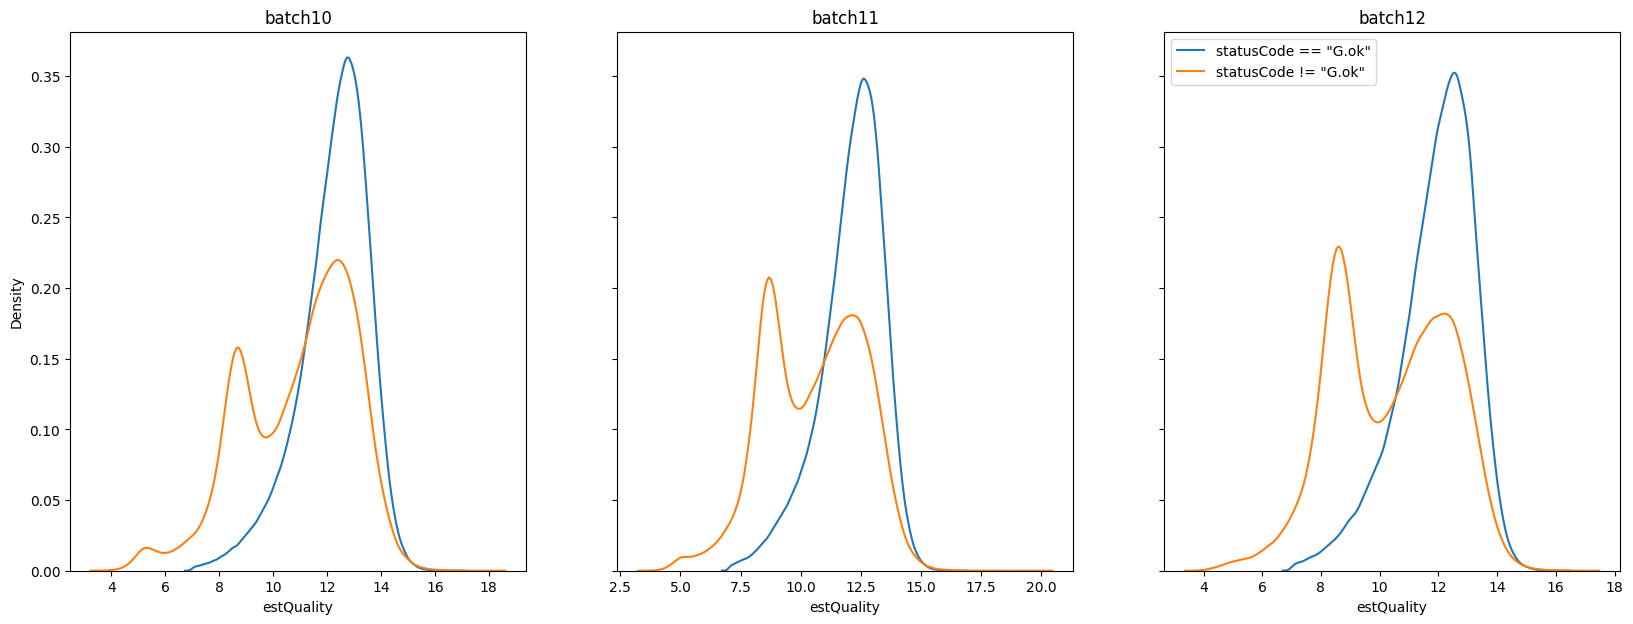

In [34]:
podmienka1_vs_podmienka2('statusCode == "G.ok"', 'statusCode != "G.ok"', 'statusCode == "G.ok"','statusCode != "G.ok"' )

Ešte sme sa pozreli na čitania ktoré boli zohľadnené teda použité v študií z ktorej naše dáta pochádzajú. Čitania klasifikované ako "G.ok" sú tie ktore splňajú podmienky: obidva konce readu musia mať rozoznateľný barcode + dostatočnú dlžku readu a tiež dostatočnu kvalitu. Tieto teda boli použité na vyvodenie záverov v štúdii. Ukázalo sa nijaké rozdelenie hodnôt estQuality okolo 12.5


# Analýza referenčného genómu

Pozrieme sa na nejaké vlastnosti vzoriek vzhľadom na polohu regiónu v referenčnom genóme, na ktorý sa namapovali

## Použité funkcie

Výpis funkcií použitých v tejto kapitole.

In [35]:
def patient_to_coverage(barcode1, merged_df):
  '''
  funkcia dostane ako argumenty barcode konkrétneho pacienta a merged tabuľku
  vytvorí dataframe s riadkom na každú bázu referenčného genómu
  pre každú vzorku funkcie sa pozrie, kde začína a končí zodpovedajúci región
    pre tieto riadky pripočíta vybrané štatistiky
  '''

  # vyfiltrujeme z merged tabuľky iba požadovaného pacienta a potrebné stĺpce
  patient = (merged_df.query(f'barcode1 == "{barcode1:02d}"')
                      .loc[:, ['ID', 'referenceStart', 'referenceEnd',
                              'estQuality', 'identicalPerc',
                              'lengthReads', 'lengthMatch',
                              'strand', 'statusCode', 'Pango']])
  
  # pripravíme si stĺpce pre výslednú tabuľku
  # hodnoty pre danú bázu sa menia len vtedy, keď je v zodpovedajúcom regióne vzorky
  refLength = 29903
  data = {'occs': [0] * refLength,      # koľkokrát bola báza v zodpovedajúcom regióne
          'sumEstQuality': [0] * refLength,   # suma odhadovaných kvalít vzoriek pre túto bázu
          'sumIdenticalPerc': [0] * refLength,  # suma percent zhodných báz
          'sumLengthReads': [0] * refLength,  # suma dĺžky vzoriek
          'sumLengthMatch': [0] * refLength,  # suma dĺžky zodpovedajúceho regiónu
          'sumStrand+': [0] * refLength,      # koľko vzoriek pre túto bázu bolo z + vlákna
          'sumStrand-': [0] * refLength,    # koľko vzoriek pre túto bázu bolo z - vlákna
          'sumStatusOK': [0] * refLength,   # koľko vzoriek pre túto bázu malo G.ok statusCode
          'sumStatusNotOK': [0] * refLength} # koľko vzoriek pre túto bázu nemalo G.ok statusCode
  
  # spojíme stĺpce do dataframeu
  coverage = pd.DataFrame(data=data)
  
  # prechádzame vzorky pacienta a na indexoch od referenceStart do referenceEnd
  #   pripočítame vybrané štatistiky
  for row in patient.iterrows():
    start = row[1]['referenceStart']
    end = row[1]['referenceEnd']

    quality = row[1]['estQuality']
    identical = row[1]['identicalPerc']
    reads = row[1]['lengthReads']
    length_match = row[1]['lengthMatch']
    strand = row[1]['strand']
    status = row[1]['statusCode']

    # značíme si, koľkokrát bola báza v zodpovedajúcom regióne
    coverage.loc[start:(end+1), 'occs'] += 1    

    # zvyšné štatistiky
    for col, stat in zip(('sumEstQuality', 'sumIdenticalPerc', 'sumLengthReads', 'sumLengthMatch'),
                         (quality, identical, reads, length_match)):
        coverage.loc[start:(end+1), col] += stat

    if strand == '+':
      coverage.loc[start:(end+1), 'sumStrand+'] += 1
    else:
      coverage.loc[start:(end+1), 'sumStrand-'] += 1
    
    if status == 'G.ok':
      coverage.loc[start:(end+1), 'sumStatusOK'] += 1
    else:
      coverage.loc[start:(end+1), 'sumStatusNotOK'] += 1

  return coverage


def coverage_analysis(coverage):
  '''
  dostane na vstupe tabuľku, ktorá je výstupom funkcie patient_to_coverage
  spracuje „surové" dáta (napr. sumy na priemery)
  '''
  
  post_coverage = coverage.copy(deep=True)

  # zapamätáme si stĺpce, ktoré chceme nahradiť spracovanými dátami
  start_col_names = ('sumEstQuality', 'sumIdenticalPerc', 'sumLengthReads', 'sumLengthMatch')
  end_col_names = ('avgEstQuality', 'avgIdenticalPerc', 'avgLengthReads', 'avgLengthMatch')

  # vybrané sumy nahradíme priemermi
  for start, end in zip(start_col_names, end_col_names):
    post_coverage[end] = post_coverage[start] / post_coverage['occs']
  
  # pre sumy vzoriek z + alebo - vlákna zapamätáme len to, z ktorého sa čítalo viac
  post_coverage['dominantStrand'] = ''
  for row in post_coverage.iterrows():
    if row[1]['sumStrand+'] >= row[1]['sumStrand-']:
      post_coverage.loc[row[0], 'dominantStrand'] = '+'
    else:
      post_coverage.loc[row[0], 'dominantStrand'] = '-'
  
  # vyhodíme stĺpce s nespracovanými dátami
  for name in start_col_names + ('sumStrand+', 'sumStrand-'):
    del post_coverage[name]

  # stĺpce sumStatusOK a sumStatusNotOK bez zmeny
  #   pri našej analýze sú tieto stĺpce zbytočné, ale chceli sme zachovať
  #   funkciu bez zmeny, ak by sme sa rozhodli spracovať všetky dáta

  # pre prehľadnejšiu manipuláciu pridáme stĺpec 'base', ktorý označuje 
  #   poradové číslo bázy pre daný riadok
  post_coverage.insert(0, 'base', range(1, (post_coverage.shape[0] + 1)))
  return post_coverage


def load_coverage_of_patient(batch_num, patient_num):
  # jednorázove načítanie coverage dát pre jedného pacienta zo stránky

  patient_num == f'{patient_num:02d}'   # upravenie patient_num do požadovaného formátu
  cov_all = load_data('all', 'coverage')    # načítanie celej coverage tabuľky

  # vrátenie vyfiltrovaných riadkov, ktoré majú správny batchNum a patientNum
  return cov_all.query(f'batchNum == @batch_num and patientNum == @patient_num').set_index('base')


def patient_from_coverage(batch_num, patient_num, coverage_df):
  # ak máme načítanú celú coverage tabuľku, rýchlejšie vráti dáta konkrétneho pacienta

  patient_num == f'{patient_num:02d}'   # upravenie patient_num do požadovaného formátu
  return coverage_df.query(f'batchNum == @batch_num and patientNum == @patient_num').set_index('base')

## Vytvorenie tabuľky

Spracujeme tabuľky pre všetkých pacientov a spojíme do jednej tabuľky.

*Nasledujúca bunka kvôli veľkej časovej a pamäťovej náročnosti sa nedá spustiť v prostredí Colab, ale keďže sú tieto dáta relevantné v ďalšej analýze, chceli sme ukázať aj ich vznik.*

In [36]:
%%script echo Skipped

# načítame merged tabuľky
merged10 = load_data(10, 'merged').sort_index().query('statusCode == "G.ok"')
merged11 = load_data(11, 'merged').sort_index().query('statusCode == "G.ok"')
merged12 = load_data(12, 'merged').sort_index().query('statusCode == "G.ok"')

merged_dfs = (merged10, merged11, merged12)

# vytvorené dataframes budeme ukladať do listu
lst_coverages = []
for batch_num in 10, 11, 12:
  for patient_num in range(1,25):
    if batch_num == 12 and patient_num == 20: continue  # tento pacient nebol v dátach

    # pre každého pacienta vytvoríme a spracujeme dáta funkciami popísanými vyššie
    coverage = patient_to_coverage(patient_num, merged_dfs[batch_num - 10])
    post_coverage = coverage_analysis(coverage)

    # pridáme identifikátor
    post_coverage.insert(0, 'patientNum', patient_num)
    post_coverage.insert(0, 'batchNum', batch_num)
    
    # vložíme do listu
    lst_coverages.append(post_coverage)

# spojíme všetky tabuľky do jednej a exportujeme
rslt = pd.concat(lst_coverages).reset_index(drop=True)
rslt.to_csv('batchall-coverage.gz', sep='\t', compression='gzip')
# files.download('batchall-coverage.gz')

Skipped


## Ukážka spracovaných dát

In [37]:
coverage_all = load_data('all', 'coverage')
coverage_all.sample(4).sort_index()

,batchNum,patientNum,base,occs,sumStatusOK,sumStatusNotOK,avgEstQuality,avgIdenticalPerc,avgLengthReads,avgLengthMatch,dominantStrand
98455,10,4,8747,994,994,0,12.492049,94.843863,2121.065392,2003.942656,+
850981,11,5,13698,1800,1800,0,12.028909,94.316111,1904.299444,1786.477222,+
904935,11,7,7846,938,938,0,12.362364,94.749254,2115.299574,1998.324094,+
1750721,12,11,16348,949,949,0,11.822842,93.940569,2013.580611,1895.265543,+


In [38]:
coverage_patient = load_coverage_of_patient(11, 6)
coverage_patient.sample(4).sort_index()

# jednorázové načítanie zo stránky - trvá približne 10s

,batchNum,patientNum,occs,sumStatusOK,sumStatusNotOK,avgEstQuality,avgIdenticalPerc,avgLengthReads,avgLengthMatch,dominantStrand
base,,,,,,,,,,
2566,11,6,3519,3519,0,12.009316,94.376158,1909.272521,1789.816993,-
16924,11,6,3512,3512,0,11.952619,94.253929,2022.392654,1903.511390,+
27115,11,6,2729,2729,0,12.082121,94.054855,2059.742396,1940.719678,-
28393,11,6,5410,5410,0,11.944341,93.529353,1878.207579,1758.619778,+


In [39]:
coverage_patient2 = patient_from_coverage(11, 6, coverage_all)
coverage_patient2.sample(4).sort_index()

# vyfiltrovanie už načítanej celej coverage tabuľky - trvá menej ako sekundu

,batchNum,patientNum,occs,sumStatusOK,sumStatusNotOK,avgEstQuality,avgIdenticalPerc,avgLengthReads,avgLengthMatch,dominantStrand
base,,,,,,,,,,
6219,11,6,1228,1228,0,12.072589,94.354967,1949.742671,1830.374593,+
23425,11,6,4237,4237,0,12.113435,94.206136,2058.020533,1938.761152,+
25688,11,6,1454,1454,0,11.934936,94.103714,1982.578404,1862.995873,-
26042,11,6,1453,1453,0,11.938855,94.106469,1982.824501,1863.238128,-


## Pokrytie referenčného genómu

V tejto časti sa venujeme vykresľovaniu grafov pre počty, koľkokrát bola daná báza referenčného genómu v zodpovedajúcom regióne.

In [40]:
# zadefinujeme si funkciu na vykresľovanie grafov pre stĺpec 'occs'

def plot_occs_from_coverage(batch_num, patient_num, coverage):
  fig, ax = plt.subplots(1, figsize=(10,5))

  coverage['occs'].plot(ax=ax)
  ax.set_title(f'Coverage of bases in reference genome\nbatch {batch_num}, patient {patient_num:02d}')
  ax.set_xlabel('index of a base in the reference genome')
  ax.set_ylabel('n. o. occurrences in patient samples')

  return fig, ax

In [41]:
# načítame celú tabuľku coverage
coverage_all = load_data('all', 'coverage')

In [42]:
# patient 6 z batchu 11 ako modelový príklad
batch_num = 11
patient_num = 6
coverage_model = patient_from_coverage(batch_num, patient_num, coverage_all)

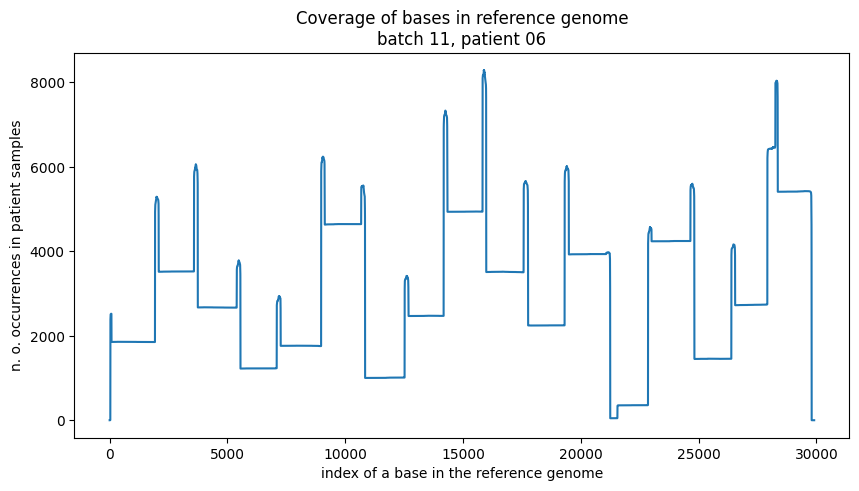

In [43]:
# vykreslíme dáta pre stĺpec 'occs'

fig, ax = plot_occs_from_coverage(batch_num, patient_num, coverage_model)

fig.savefig('coverage.png')

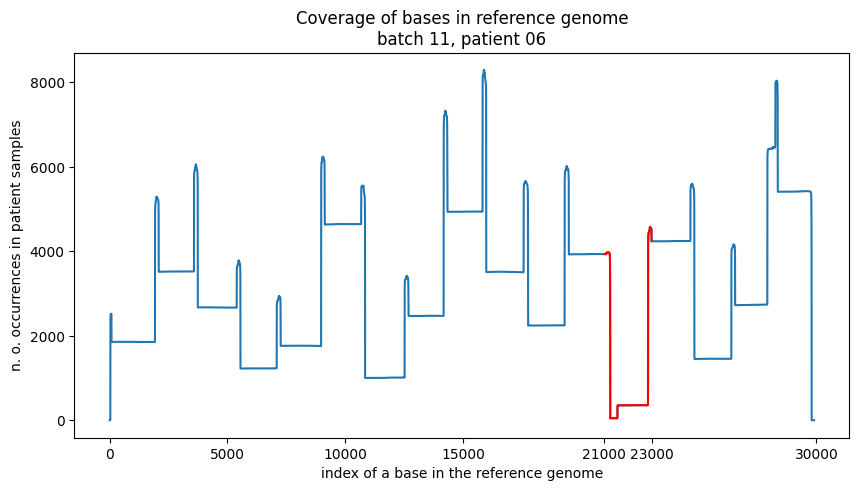

In [44]:
# vykreslíme rovnaký graf, ale farebne odlíšime región, kde je pokrytie konzistentne nízke
# čiže medzi bázami 21000 až 23000

fig, ax = plot_occs_from_coverage(batch_num, patient_num, coverage_model)
coverage_model.query('21000 < base < 23000')['occs'].plot(ax=ax, color='red', 
                                                          xticks=(0, 5000, 10000, 15000, 21000, 23000, 30000))

# napravíme prepísaný názov x-ovej osi
ax.set_xlabel('index of a base in the reference genome')

fig.savefig('coverage-highlighted.png')

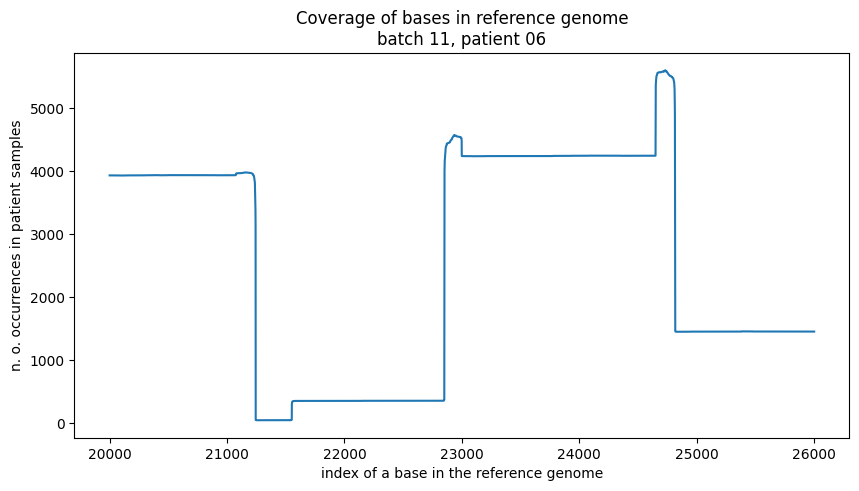

In [45]:
# znova vykreslíme graf, ale x-ovú os obmedzíme na 20000 až 26000

fig, ax = plot_occs_from_coverage(batch_num, patient_num, coverage_model.query("20000 <= base <= 26000"))

fig.savefig('coverage-zoomed.png')

In [46]:
%%script echo Skipped
files.download('coverage.png')
files.download('coverage-highlighted.png')
files.download('coverage-zoomed.png')

Skipped


Popis grafov a prečo sme sa zamerali na región medzi bázami 21000 až 23000 je napísané v správe.

In [47]:
# vygenerujeme grafy pre všetkých pacientov

for batch_num in 10, 11, 12:
  for patient_num in range(1, 25):
    if batch_num == 12 and patient_num == 20: continue

    coverage = patient_from_coverage(batch_num, patient_num, coverage_all)
    fig, ax = plot_occs_from_coverage(batch_num, patient_num, coverage)

    fig.savefig(f'coveragePlot-batch{batch_num}-patient{patient_num:02d}.png')
    # files.download(f'coveragePlot-batch{batch_num}-patient{patient_num:02d}.png')
    plt.close(fig)

pass

## Priemerná odhadovaná kvalita referenčného genómu

V tejto časti sa venujeme vykresľovaniu grafov pre primernú odhadovanú kvalitu vzoriek, pre ktoré bola daná báza v zodpovedajúcom regióne.

In [48]:
# zadefinujeme si funkciu na vykresľovanie grafov pre stĺpec 'occs'

def plot_estQuality_from_coverage(batch_num, patient_num, coverage):
  fig, ax = plt.subplots(1, figsize=(10,5))

  coverage['avgEstQuality'].plot(ax=ax)
  ax.set_title(f'Average estimated quality on a base\nbatch {batch_num}, patient {patient_num:02d}')
  ax.set_xlabel('index of a base in the reference genome')
  ax.set_ylabel('average estimated quality in patient samples')
  
  return fig, ax

In [49]:
# patient 14 z batchu 11 ako modelový príklad
batch_num2 = 11
patient_num2 = 14
coverage_model2 = patient_from_coverage(batch_num2, patient_num2, coverage_all)

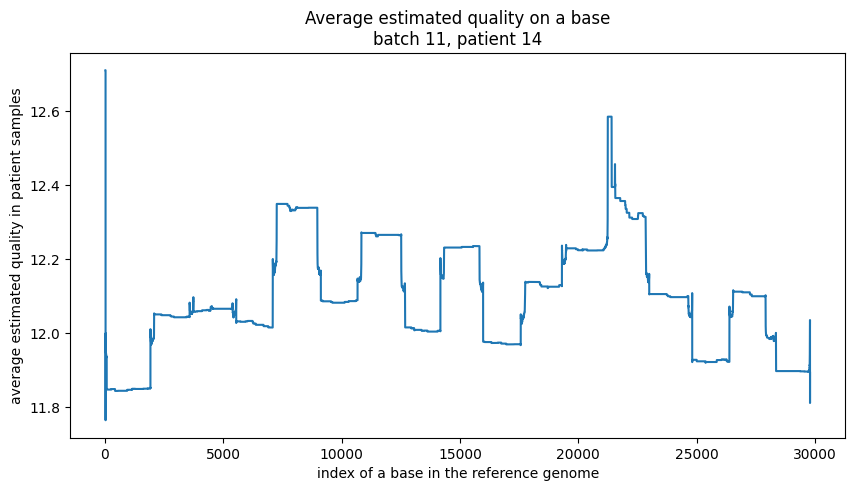

In [50]:
# vykreslíme dáta pre stĺpec 'avgEstQuality

fig, ax = plot_estQuality_from_coverage(batch_num2, patient_num2, coverage_model2)

fig.savefig('estQuality.png')

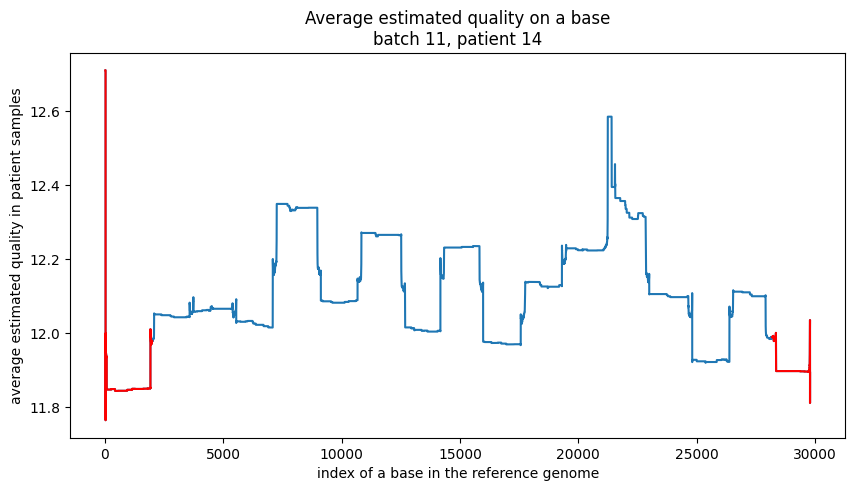

In [51]:
# vykreslíme rovnaký graf, ale farebne odlíšime začiatočných a koncových 2000 báz

fig, ax = plot_estQuality_from_coverage(batch_num2, patient_num2, coverage_model2)
coverage_model2.query('0 < base < 2000')['avgEstQuality'].plot(ax=ax, color='red')
coverage_model2.query('28200 < base < 30000')['avgEstQuality'].plot(ax=ax, color='red')

# napravíme prepísaný názov x-ovej osi
ax.set_xlabel('index of a base in the reference genome')

fig.savefig('estQuality-highlighted.png')

In [52]:
%%script echo Skipped
files.download('estQuality.png')
files.download('estQuality-highlighted.png')

Skipped


Aj pre tieto grafy platí, že prečo sme sa zamerali na tieto regióny a popis grafu je napísané v správe.

In [53]:
# vygenerujeme grafy pre všetkých pacientov

for batch_num in 10, 11, 12:
  for patient_num in range(1, 25):
    if batch_num == 12 and patient_num == 20: continue

    coverage = patient_from_coverage(batch_num, patient_num, coverage_all)
    fig, ax = plot_estQuality_from_coverage(batch_num, patient_num, coverage)

    fig.savefig(f'estQualityPlot-batch{batch_num}-patient{patient_num:02d}.png')
    # files.download(f'estQualityPlot-batch{batch_num}-patient{patient_num:02d}.png')
    plt.close(fig)

pass